In [1]:
import pickle
from tqdm import tqdm

import numpy as np
from scipy.sparse.csgraph import connected_components, shortest_path
import torch
from torch.func import jacrev
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import degree, to_undirected
import matplotlib.pyplot as plt

from utils.parse_logs import parse_metrics
from model import Model as Base

In [2]:
def compute_commute_times(adj, P=0.):

    adj = to_undirected(adj.type(torch.int64))
    degrees = degree(adj[0], num_nodes=adj.max()+1)
    A = torch.zeros((degrees.size(0), degrees.size(0)))
    A[adj[0], adj[1]] = 1.
    assert connected_components(A, directed=False, return_labels=False) == 1

    L = torch.diag(degrees) - A
    L_pinv = torch.linalg.pinv(L)
    L_pinv_diag = torch.diag(L_pinv)
    
    beta = torch.sum(degrees / (1 - P**degrees))
    C = beta * (L_pinv_diag.unsqueeze(0) + L_pinv_diag.unsqueeze(1) - 2*L_pinv)

    return C

In [3]:
def compute_shortest_distances(adj):

    adj = to_undirected(adj.type(torch.int64))
    degrees = degree(adj[0], num_nodes=adj.max()+1)
    A = torch.zeros((degrees.size(0), degrees.size(0)))
    A[adj[0], adj[1]] = 1.
    assert connected_components(A, directed=False, return_labels=False) == 1

    shortest_distances = torch.from_numpy(shortest_path(A.numpy(), directed=False))
    
    return shortest_distances

In [4]:
dataset = TUDataset(root='./data', name='Proteins', use_node_attr=True)
num_nodes = np.array([molecule.num_nodes for molecule in dataset])

while True:
    i = np.random.choice(np.where((30 <= num_nodes) & (num_nodes <= 70))[0])
    molecule = dataset[i]
    try:
        commute_times = compute_commute_times(molecule.edge_index, P=0.)
    except AssertionError:
        continue
    shortest_distances = compute_shortest_distances(molecule.edge_index)
    break

i, molecule.num_nodes, commute_times.size(), shortest_distances.size()

(378, 32, torch.Size([32, 32]), torch.Size([32, 32]))

In [5]:
dir_names = {
    0.0: './results/model-store/2024-07-10-23-24-26',
    0.3: './results/model-store/2024-07-10-22-57-45',
    0.5: './results/model-store/2024-07-10-22-44-40',
    0.7: './results/model-store/2024-07-10-22-52-47',
}

In [6]:
class Model(Base):
    def forward(self, edge_index, mask, x):
        for mp_layer in self.message_passing:
            x = mp_layer(x, edge_index)
        return x

In [7]:
def get_jacobian_norms(dir_name, n_samples=10, use_trained=False):

    with open(f'{dir_name}/config.pkl', 'rb') as f:
        config = pickle.load(f)

    model = Model(config)
    state_dict = torch.load(f'{dir_name}/ckpt-400.pt')
    if use_trained:
        model.load_state_dict(state_dict)

    n_samples = n_samples if config.drop_p > 0. else 1

    jacobians = torch.zeros((molecule.num_nodes, config.gnn_layer_sizes[-1], molecule.num_nodes, config.input_dim))
    for _ in range(n_samples):
        jacobians += jacrev(model, argnums=2)(molecule.edge_index, None, molecule.x)
    jacobians /= n_samples
    jacobian_norms = jacobians.transpose(1, 2).flatten(start_dim=2).norm(dim=2, p=1)

    return jacobian_norms

In [8]:
ps = (0.0, 0.3, 0.5, 0.7)
n_samples = 10
use_trained = False

jacobian_norms_ps = [get_jacobian_norms(dir_names[p], n_samples=n_samples, use_trained=use_trained) for p in tqdm(ps)]

100%|██████████| 4/4 [00:30<00:00,  7.52s/it]


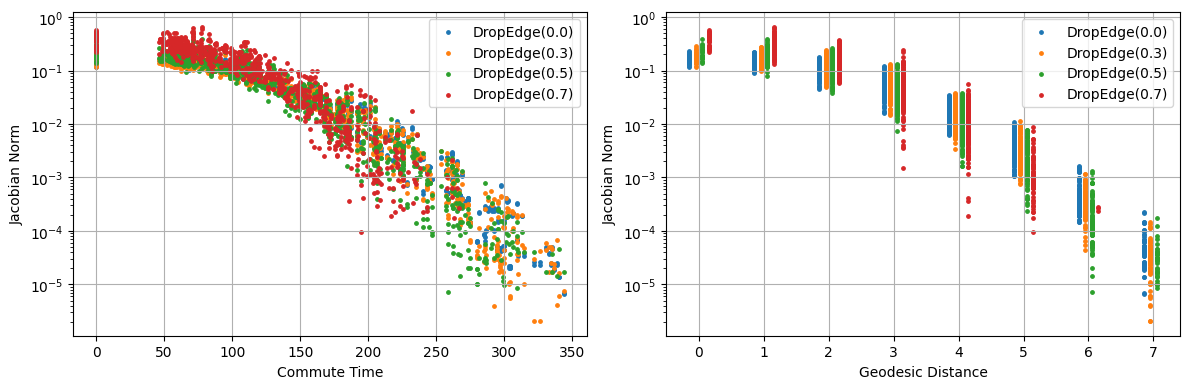

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
x = commute_times.flatten()
for p, jacobian_norms in zip(ps, jacobian_norms_ps):
    mask = torch.where(jacobian_norms.flatten() != 0.)[0]
    ax.scatter(x[mask], jacobian_norms.flatten().detach()[mask], s=6, label=f'DropEdge({p})')
ax.set_xlabel('Commute Time')
ax.set_ylabel('Jacobian Norm')
ax.set_yscale('log')
ax.grid()
ax.legend()

ax = axs[1]
x = shortest_distances.flatten()
gap = 0.1
shifts = np.arange(0.0, gap*len(ps), gap) - gap*(len(ps)-1)/2
for p, jacobian_norms, shift in zip(ps, jacobian_norms_ps, shifts):
    mask = torch.where(jacobian_norms.flatten() != 0.)[0]
    ax.scatter(x[mask] + shift, jacobian_norms.flatten().detach()[mask], s=6, label=f'DropEdge({p})')
ax.set_xlabel('Geodesic Distance')
ax.set_ylabel('Jacobian Norm')
ax.set_yscale('log')
ax.grid()
ax.legend()

fig.tight_layout()
plt.show()

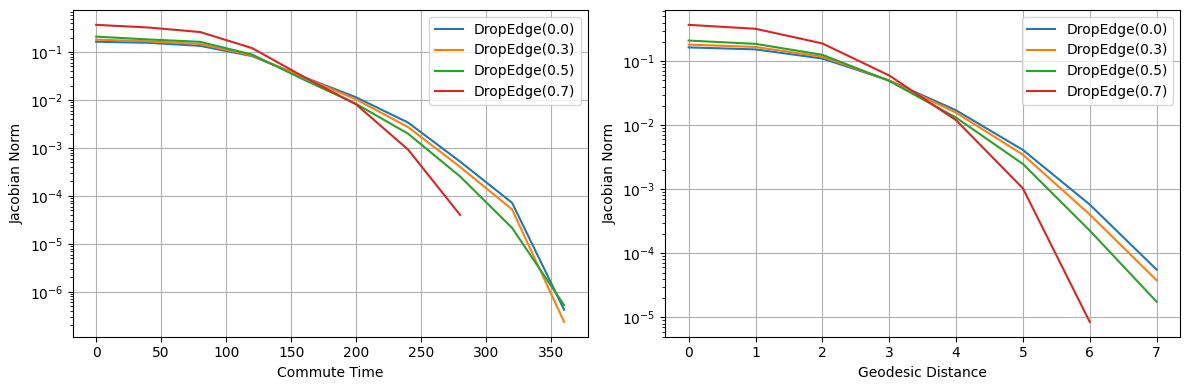

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

### COMMUTE TIMES ###

ax = axs[0]

b = 40.
binned_commute_times = torch.round(commute_times/b) * b
binned_commute_times = binned_commute_times.flatten()
x = binned_commute_times.flatten().unique()

for p, jacobian_norms in zip(ps, jacobian_norms_ps):
    y = jacobian_norms.flatten().detach()
    lower, means, upper = list(), list(), list()
    for bin_pos in x:
        std, mean = torch.std_mean(y[torch.where(binned_commute_times == bin_pos)])
        lower.append(mean-std)
        means.append(mean)
        upper.append(mean+std)
    end = np.where(np.array(means) != 0.)[0][-1] + 1
    ax.plot(x[:end], means[:end], label=f'DropEdge({p})')
    # ax.fill_between(x[:end], lower[:end], upper[:end], color='blue', alpha=0.2)

ax.set_xlabel('Commute Time')
ax.set_ylabel('Jacobian Norm')
ax.set_yscale('log')
ax.grid()
ax.legend()

### SHORTEST DISTANCE ###

ax = axs[1]

shortest_distances_flat = shortest_distances.flatten()
x = shortest_distances_flat.unique()

for p, jacobian_norms in zip(ps, jacobian_norms_ps):
    y = jacobian_norms.flatten().detach()
    lower, means, upper = list(), list(), list()
    for bin_pos in x:
        std, mean = torch.std_mean(y[torch.where(shortest_distances_flat == bin_pos)])
        lower.append(mean-std)
        means.append(mean)
        upper.append(mean+std)
    end = np.where(np.array(means) != 0.)[0][-1] + 1
    ax.plot(x[:end], means[:end], label=f'DropEdge({p})')
    # ax.fill_between(x[:end], lower[:end], upper[:end], color='green', alpha=0.2)

ax.set_xlabel('Geodesic Distance')
ax.set_ylabel('Jacobian Norm')
ax.set_yscale('log')
ax.grid()
ax.legend()

###

fig.tight_layout()
plt.show()

All crossovers happen around the same geodesic distance.

In [11]:
del jacobian_norms_ps

In [12]:
ps = (0.0, 0.3, 0.5, 0.7)
n_samples = 10
use_trained = True

jacobian_norms_ps = [get_jacobian_norms(dir_names[p], n_samples=n_samples, use_trained=use_trained) for p in tqdm(ps)]

100%|██████████| 4/4 [00:34<00:00,  8.52s/it]


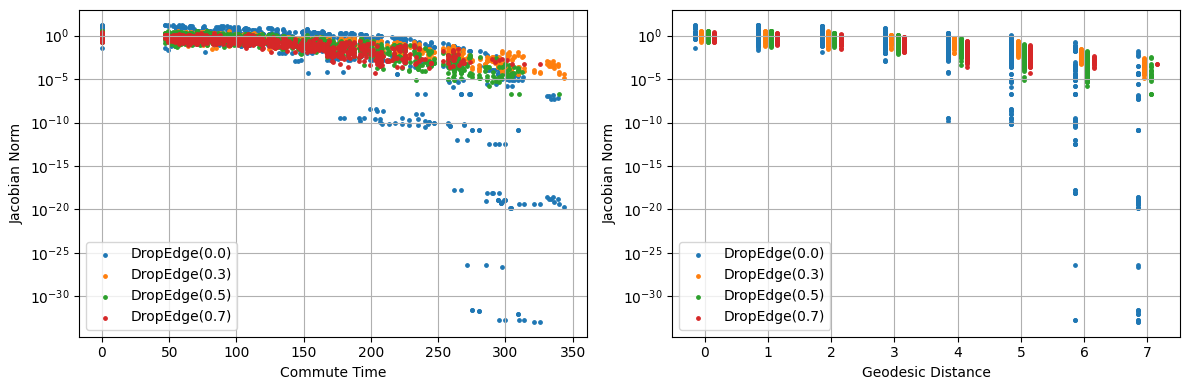

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
x = commute_times.flatten()
for p, jacobian_norms in zip(ps, jacobian_norms_ps):
    mask = torch.where(jacobian_norms.flatten() != 0.)[0]
    ax.scatter(x[mask], jacobian_norms.flatten().detach()[mask], s=6, label=f'DropEdge({p})')
ax.set_xlabel('Commute Time')
ax.set_ylabel('Jacobian Norm')
ax.set_yscale('log')
ax.grid()
ax.legend()

ax = axs[1]
x = shortest_distances.flatten()
gap = 0.1
shifts = np.arange(0.0, gap*len(ps), gap) - gap*(len(ps)-1)/2
for p, jacobian_norms, shift in zip(ps, jacobian_norms_ps, shifts):
    mask = torch.where(jacobian_norms.flatten() != 0.)[0]
    ax.scatter(x[mask] + shift, jacobian_norms.flatten().detach()[mask], s=6, label=f'DropEdge({p})')
ax.set_xlabel('Geodesic Distance')
ax.set_ylabel('Jacobian Norm')
ax.set_yscale('log')
ax.grid()
ax.legend()

fig.tight_layout()
plt.show()

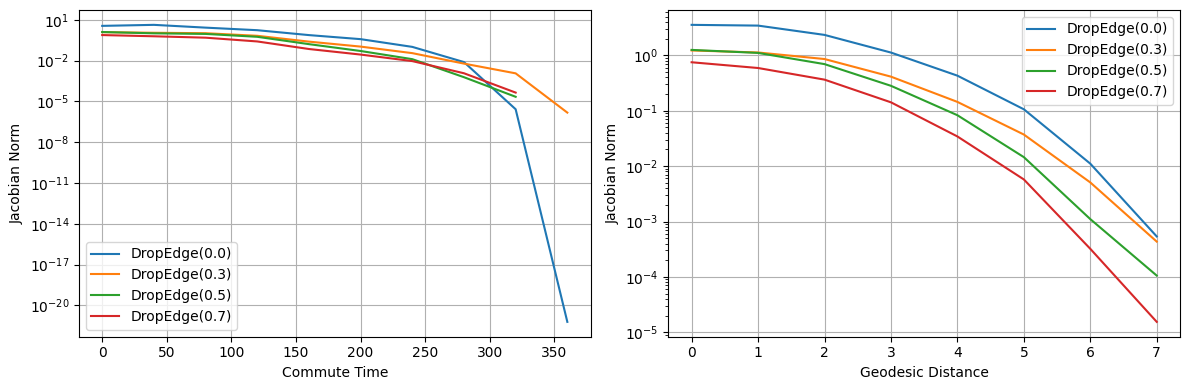

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

### COMMUTE TIMES ###

ax = axs[0]

b = 40.
binned_commute_times = torch.round(commute_times/b) * b
binned_commute_times = binned_commute_times.flatten()
x = binned_commute_times.flatten().unique()

for p, jacobian_norms in zip(ps, jacobian_norms_ps):
    y = jacobian_norms.flatten().detach()
    lower, means, upper = list(), list(), list()
    for bin_pos in x:
        std, mean = torch.std_mean(y[torch.where(binned_commute_times == bin_pos)])
        lower.append(mean-std)
        means.append(mean)
        upper.append(mean+std)
    end = np.where(np.array(means) != 0.)[0][-1] + 1
    ax.plot(x[:end], means[:end], label=f'DropEdge({p})')
    # ax.fill_between(x[:end], lower[:end], upper[:end], color='blue', alpha=0.2)

ax.set_xlabel('Commute Time')
ax.set_ylabel('Jacobian Norm')
ax.set_yscale('log')
ax.grid()
ax.legend()

### SHORTEST DISTANCE ###

ax = axs[1]

shortest_distances_flat = shortest_distances.flatten()
x = shortest_distances_flat.unique()

for p, jacobian_norms in zip(ps, jacobian_norms_ps):
    y = jacobian_norms.flatten().detach()
    lower, means, upper = list(), list(), list()
    for bin_pos in x:
        std, mean = torch.std_mean(y[torch.where(shortest_distances_flat == bin_pos)])
        lower.append(mean-std)
        means.append(mean)
        upper.append(mean+std)
    end = np.where(np.array(means) != 0.)[0][-1] + 1
    ax.plot(x[:end], means[:end], label=f'DropEdge({p})')
    # ax.fill_between(x[:end], lower[:end], upper[:end], color='green', alpha=0.2)

ax.set_xlabel('Geodesic Distance')
ax.set_ylabel('Jacobian Norm')
ax.set_yscale('log')
ax.grid()
ax.legend()

###

fig.tight_layout()
plt.show()

In [15]:
def get_best_accuracies(dir_name):

    train, val, test = parse_metrics(f'{dir_name}/logs')
    return max(train['Accuracy']), test['Accuracy'][np.argmax(val['Accuracy'])]

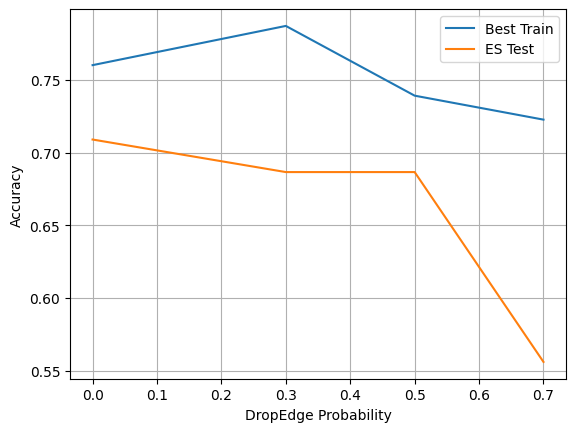

In [16]:
train_accs, es_test_accs = zip(*(get_best_accuracies(dir_names[p]) for p in ps))

plt.plot(ps, train_accs, label='Best Train')
plt.plot(ps, es_test_accs, label='ES Test')
plt.xlabel('DropEdge Probability')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()